<img src="data/photutils_banner.svg">

## Photutils

- Code: https://github.com/astropy/photutils
- Documentation: http://photutils.readthedocs.org/en/stable/
- Issue Tracker:  https://github.com/astropy/photutils/issues

## Photutils Overview

- Background and background noise estimation
- Source Detection and Extraction
  - DAOFIND and IRAF's starfind
  - **Image segmentation**
  - local peak finder
- **Aperture photometry**
- PSF photometry
- PSF matching
- Centroids
- Morphological properties
- Elliptical isophote analysis



## Preliminaries

In [1]:
# initial imports
import numpy as np
import matplotlib.pyplot as plt

# change some default plotting parameters
import matplotlib as mpl
mpl.rcParams['image.origin'] = 'lower'
mpl.rcParams['image.interpolation'] = 'nearest'
mpl.rcParams['image.cmap'] = 'viridis'

# Run the %matplotlib magic command to enable inline plotting
# in the current notebook.  Choose one of these:
%matplotlib inline
# %matplotlib notebook

### Load the data

We'll start by reading data and error arrays from FITS files.  These are cutouts from the HST Extreme-Deep Field (XDF) taken with WFC3/IR in the F160W filter.

In [2]:
from astropy.io import fits
sci_fn = 'data/xdf_hst_wfc3ir_60mas_f160w_sci.fits'
rms_fn = 'data/xdf_hst_wfc3ir_60mas_f160w_rms.fits'
sci_hdulist = fits.open(sci_fn)
rms_hdulist = fits.open(rms_fn)

sci_hdulist[0].header['BUNIT'] = 'electron/s'

Print some info about the data.

In [3]:
sci_hdulist.info()

Filename: data/xdf_hst_wfc3ir_60mas_f160w_sci.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      42   (200, 200)   float32   


Define the data and error arrays.

In [4]:
data = sci_hdulist[0].data.astype(np.float)
error = rms_hdulist[0].data.astype(np.float)

Extract the data header and create a WCS object.

In [5]:
from astropy.wcs import WCS

hdr = sci_hdulist[0].header
wcs = WCS(hdr)

Display the data.

Text(0.5, 1.0, 'XDF F160W Cutout')

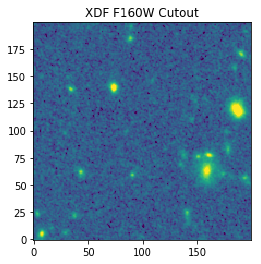

In [6]:
from astropy.visualization import simple_norm
norm = simple_norm(data, 'sqrt', percent=99.5)
plt.imshow(data, norm=norm)
plt.title('XDF F160W Cutout')

## Part 1:  Aperture Photometry

Photutils provides circular, elliptical, and rectangular aperture shapes (plus annulus versions of each).  These are names of the aperture classes, defined in pixel coordinates:

* `CircularAperture`
* `CircularAnnulus`

* `EllipticalAperture`
* `EllipticalAnnulus`

* `RectangularAperture`
* `RectangularAnnulus`

Along with variants of each, defined in celestial coordinates:

* `SkyCircularAperture`
* `SkyCircularAnnulus`

* `SkyEllipticalAperture`
* `SkyEllipticalAnnulus`

* `SkyRectangularAperture`
* `SkyRectangularAnnulus`

## Methods for handling aperture/pixel intersection

In general, the apertures will only partially overlap some of the pixels in the data.

There are three methods for handling the aperture overlap with the pixel grid of the data array.

<img src="data/photutils_aperture_methods.svg">

NOTE:  the `subpixels` keyword is ignored for the **'exact'** and **'center'** methods.

### Perform circular-aperture photometry on some sources in the XDF

First, we define a circular aperture at a given position and radius (in pixels).

In [7]:
from photutils import CircularAperture

position = (90.73, 59.43)  # (x, y) pixel position
radius = 5.  # pixels
aperture = CircularAperture(position, r=radius)

In [8]:
aperture

<CircularAperture([[90.73, 59.43]], r=5.0)>

In [9]:
print(aperture)

Aperture: CircularAperture
positions: [[90.73, 59.43]]
r: 5.0


We can plot the aperture on the data using the aperture `plot()` method:

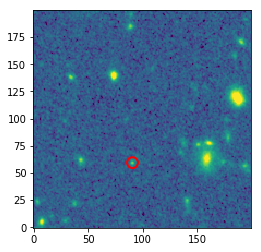

In [10]:
plt.imshow(data, norm=norm)
aperture.plot(color='red', lw=2)

Now let's perform photometry on the data using the `aperture_photometry()` function.  **The default aperture method is 'exact'.**

Also note that the input data is assumed to have zero background.  If that is not the case, please see the documentation for the `photutils.background` subpackage for tools to help subtract the background.

See the `photutils_local_background.ipynb` notebook for examples of local background subtraction.

The background was already subtracted for our XDF example data.

In [11]:
from photutils import aperture_photometry

phot = aperture_photometry(data, aperture)
phot

id,xcenter,ycenter,aperture_sum
,pix,pix,
int64,float64,float64,float64
1,90.73,59.43,0.12039154582527045


The output is an Astropy `QTable` (Quantity Table) with sum of data values within the aperture (using the defined pixel overlap method).

The table also contains metadata, which is accessed by the `meta` attribute of the table.  The metadata is stored as a python (ordered) dictionary:

In [12]:
phot.meta

OrderedDict([('name', 'Aperture photometry results'),
             ('version', 'astropy: 3.0.4, photutils: 0.5'),
             ('aperture_photometry_args', "method='exact', subpixels=5")])

In [13]:
phot.meta['version']

'astropy: 3.0.4, photutils: 0.5'

Aperture photometry using the **'center'** method gives a slightly different (and less accurate) answer:

In [14]:
phot = aperture_photometry(data, aperture, method='center')
phot

id,xcenter,ycenter,aperture_sum
,pix,pix,
int64,float64,float64,float64
1,90.73,59.43,0.1202922910979396


Now perform aperture photometry using the **'subpixel'** method with `subpixels=5`:

These parameters are equivalent to SExtractor aperture photometry.

In [15]:
phot = aperture_photometry(data, aperture, method='subpixel', subpixels=5)
phot

id,xcenter,ycenter,aperture_sum
,pix,pix,
int64,float64,float64,float64
1,90.73,59.43,0.12040869806049159


## Photometric Errors

We can also input an error array to get the photometric errors.

In [16]:
phot = aperture_photometry(data, aperture, error=error)
phot

id,xcenter,ycenter,aperture_sum,aperture_sum_err
,pix,pix,,
int64,float64,float64,float64,float64
1,90.73,59.43,0.12039154582527045,0.008021175633656936


The error array in our XDF FITS file represents only the background error.  If we want to include the Poisson error of the source we need to calculate the **total** error:

$\sigma_{\mathrm{tot}} = \sqrt{\sigma_{\mathrm{b}}^2 +
                  \frac{I}{g}}$
                  
where $\sigma_{\mathrm{b}}$ is the background-only error,
$I$ are the data values, and $g$ is the "effective gain".

The "effective gain" is the value (or an array if it's variable across an image) needed to convert the data image to count units (e.g. electrons or photons), where Poisson statistics apply.

Photutils provides a `calc_total_error()` function to perform this calculation.

In [17]:
# this time include the Poisson error of the source
from photutils.utils import calc_total_error

# our data array is in units of e-/s
# so the "effective gain" should be the exposure time
eff_gain = hdr['TEXPTIME']
tot_error = calc_total_error(data, error, eff_gain)

phot = aperture_photometry(data, aperture, error=tot_error)
phot

id,xcenter,ycenter,aperture_sum,aperture_sum_err
,pix,pix,,
int64,float64,float64,float64,float64
1,90.73,59.43,0.12039154582527045,0.008044023150701417


The total error increased only slightly because this is a small faint source.

## Units

We can also input the data (and error) units via the `unit` keyword.

In [18]:
# input the data units
import astropy.units as u

unit = u.electron / u.s
phot = aperture_photometry(data, aperture, error=tot_error, unit=unit)
phot

id,xcenter,ycenter,aperture_sum,aperture_sum_err
,pix,pix,electron / s,electron / s
int64,float64,float64,float64,float64
1,90.73,59.43,0.12039154582527045,0.008044023150701417


In [19]:
phot['aperture_sum']

<Quantity [0.12039155] electron / s>

Instead of inputting units via the units keyword, `Quantity` inputs for data and error are also allowed.

In [20]:
phot = aperture_photometry(data * unit, aperture, error=tot_error * u.adu)
phot

id,xcenter,ycenter,aperture_sum,aperture_sum_err
,pix,pix,electron / s,adu
int64,float64,float64,float64,float64
1,90.73,59.43,0.12039154582527045,0.008044023150701417


The `unit` will not override the data or error unit.

In [21]:
phot = aperture_photometry(data * unit, aperture, error=tot_error * u.adu, unit=u.photon)
phot

id,xcenter,ycenter,aperture_sum,aperture_sum_err
,pix,pix,electron / s,adu
int64,float64,float64,float64,float64
1,90.73,59.43,0.12039154582527045,0.008044023150701417


## Performing aperture photometry at multiple positions

Now let's perform aperture photometry for three sources (all with the same aperture size).  We simply define three (x, y) positions.

In [22]:
positions = [(90.73, 59.43), (73.63, 139.41), (43.62, 61.63)]
radius = 5.
apertures = CircularAperture(positions, r=radius)

Let's plot these three apertures on the data.

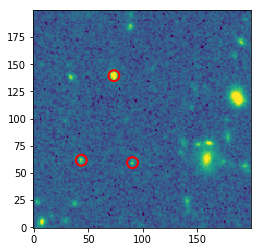

In [23]:
plt.imshow(data, norm=norm)
apertures.plot(color='red', lw=2)

Now let's perform aperture photometry.

In [24]:
phot = aperture_photometry(data, apertures, error=tot_error, unit=unit)
phot

id,xcenter,ycenter,aperture_sum,aperture_sum_err
,pix,pix,electron / s,electron / s
int64,float64,float64,float64,float64
1,90.73,59.43,0.12039154582527045,0.008044023150701417
2,73.63,139.41,0.6150243632978061,0.00816628074162013
3,43.62,61.63,0.21352615994892402,0.008069761430877863


Each source is a row in the table and is given a unique **id** (the first column).

## Adding columns to the photometry table

We can add columns to the photometry table.  Let's calculate the signal-to-noise (SNR) ratio of our sources and add it as a new column to the table.

In [25]:
snr = phot['aperture_sum'] / phot['aperture_sum_err']   # units will cancel

phot['snr'] = snr
phot

id,xcenter,ycenter,aperture_sum,aperture_sum_err,snr
,pix,pix,electron / s,electron / s,
int64,float64,float64,float64,float64,float64
1,90.73,59.43,0.12039154582527045,0.008044023150701417,14.966583706906988
2,73.63,139.41,0.6150243632978061,0.00816628074162013,75.31266469486938
3,43.62,61.63,0.21352615994892402,0.008069761430877863,26.460033766536732


Now calculate the F160W AB magnitude and add it to the table.

In [26]:
f160w_zpt = 25.9463

# NOTE that the log10() function can be applied only to dimensionless quantities
# so we use the value() method to get the number value of the aperture sum
abmag = -2.5 * np.log10(phot['aperture_sum'].value) + f160w_zpt

phot['abmag'] = abmag
phot

id,xcenter,ycenter,aperture_sum,aperture_sum_err,snr,abmag
,pix,pix,electron / s,electron / s,,
int64,float64,float64,float64,float64,float64,float64
1,90.73,59.43,0.12039154582527045,0.008044023150701417,14.966583706906988,28.24481002294352
2,73.63,139.41,0.6150243632978061,0.00816628074162013,75.31266469486938,26.474069199845104
3,43.62,61.63,0.21352615994892402,0.008069761430877863,26.460033766536732,27.622672275537816


Now, using the WCS defined above, calculate the sky coordinates for these objects and add it to the table.

In [27]:
np.transpose(positions)

array([[ 90.73,  73.63,  43.62],
       [ 59.43, 139.41,  61.63]])

In [28]:
from astropy.wcs.utils import pixel_to_skycoord

# convert pixel positions to sky coordinates
x, y = np.transpose(positions)
coord = pixel_to_skycoord(x, y, wcs)

# we can add the astropy SkyCoord object directly to the table
phot['sky coord'] = coord
phot

id,xcenter,ycenter,aperture_sum,aperture_sum_err,snr,abmag,sky coord
,pix,pix,electron / s,electron / s,,,"deg,deg"
int64,float64,float64,float64,float64,float64,float64,object
1,90.73,59.43,0.12039154582527045,0.008044023150701417,14.966583706906988,28.24481002294352,"53.158891500867604,-27.765002141410175"
2,73.63,139.41,0.6150243632978061,0.00816628074162013,75.31266469486938,26.474069199845104,"53.15921313626186,-27.763669058236427"
3,43.62,61.63,0.21352615994892402,0.008069761430877863,26.460033766536732,27.622672275537816,"53.159778816470286,-27.764965241221894"


We can also add separate RA and Dec columns, if preferred.

In [29]:
phot['ra_icrs'] = coord.icrs.ra
phot['dec_icrs'] = coord.icrs.dec
phot

id,xcenter,ycenter,aperture_sum,aperture_sum_err,snr,abmag,sky coord,ra_icrs,dec_icrs
,pix,pix,electron / s,electron / s,,,"deg,deg",deg,deg
int64,float64,float64,float64,float64,float64,float64,object,float64,float64
1,90.73,59.43,0.12039154582527045,0.008044023150701417,14.966583706906988,28.24481002294352,"53.158891500867604,-27.765002141410175",53.15888794969764,-27.76499923317225
2,73.63,139.41,0.6150243632978061,0.00816628074162013,75.31266469486938,26.474069199845104,"53.15921313626186,-27.763669058236427",53.15920958492472,-27.76366614996854
3,43.62,61.63,0.21352615994892402,0.008069761430877863,26.460033766536732,27.622672275537816,"53.159778816470286,-27.764965241221894",53.15977526527222,-27.76496233290131


If we write the table to an ASCII file using the ECSV format we can read it back in preserving all of the units, metadata, and SkyCoord objects.

In [30]:
phot.write('my_photometry.txt', format='ascii.ecsv')

In [31]:
# view the table on disk
!cat my_photometry.txt

# %ECSV 0.9
# ---
# datatype:
# - {name: id, datatype: int64}
# - {name: xcenter, unit: pix, datatype: float64}
# - {name: ycenter, unit: pix, datatype: float64}
# - {name: aperture_sum, unit: electron / s, datatype: float64}
# - {name: aperture_sum_err, unit: electron / s, datatype: float64}
# - {name: snr, datatype: float64}
# - {name: abmag, datatype: float64}
# - {name: sky coord.ra, unit: deg, datatype: float64}
# - {name: sky coord.dec, unit: deg, datatype: float64}
# - {name: ra_icrs, unit: deg, datatype: float64}
# - {name: dec_icrs, unit: deg, datatype: float64}
# meta: !!omap
# - {name: Aperture photometry results}
# - {version: 'astropy: 3.0.4, photutils: 0.5'}
# - {aperture_photometry_args: 'method=''exact'', subpixels=5'}
# - __serialized_columns__:
#     aperture_sum:
#       __class__: astropy.units.quantity.Quantity
#       value: !astropy.table.SerializedColumn {name: aperture_sum}
#     aperture_sum_err:
#       __class__: astropy.units.quantity.Quantity
#       value

Now read the table in ECSV format.

In [32]:
from astropy.table import QTable
tbl = QTable.read('my_photometry.txt', format='ascii.ecsv')
tbl

id,xcenter,ycenter,aperture_sum,aperture_sum_err,snr,abmag,sky coord,ra_icrs,dec_icrs
,pix,pix,electron / s,electron / s,,,"deg,deg",deg,deg
int64,float64,float64,float64,float64,float64,float64,object,float64,float64
1,90.73,59.43,0.12039154582527045,0.008044023150701417,14.966583706906988,28.24481002294352,"53.158891500867604,-27.765002141410175",53.15888794969764,-27.76499923317225
2,73.63,139.41,0.6150243632978061,0.00816628074162013,75.31266469486938,26.474069199845104,"53.15921313626186,-27.763669058236427",53.15920958492472,-27.76366614996854
3,43.62,61.63,0.21352615994892402,0.008069761430877863,26.460033766536732,27.622672275537816,"53.159778816470286,-27.764965241221894",53.15977526527222,-27.76496233290131


In [33]:
tbl.meta

OrderedDict([('name', 'Aperture photometry results'),
             ('version', 'astropy: 3.0.4, photutils: 0.5'),
             ('aperture_photometry_args', "method='exact', subpixels=5")])

In [34]:
tbl['aperture_sum']   # Quantity array

<Quantity [0.12039155, 0.61502436, 0.21352616] electron / s>

In [35]:
tbl['sky coord']    # SkyCoord array

<SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    [(53.1588915 , -27.76500214), (53.15921314, -27.76366906),
     (53.15977882, -27.76496524)]>

## Aperture photometry using Sky apertures

First, let's define the sky coordinates by converting our pixel coordinates.

In [36]:
positions = [(90.73, 59.43), (73.63, 139.41), (43.62, 61.63)]
x, y = np.transpose(positions)
coord = pixel_to_skycoord(x, y, wcs)
coord

<SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    [(53.1588915 , -27.76500214), (53.15921314, -27.76366906),
     (53.15977882, -27.76496524)]>

Now define circular apertures in sky coordinates.

For sky apertures, the aperture radius must be a `Quantity`, in either pixel or angular units.

In [37]:
from photutils import SkyCircularAperture

radius = 5. * u.pix
sky_apers = SkyCircularAperture(coord, r=radius)
sky_apers.r

<Quantity 5. pix>

In [38]:
radius = 0.5 * u.arcsec
sky_apers = SkyCircularAperture(coord, r=radius)
sky_apers.r

<Quantity 0.5 arcsec>

When using a sky aperture in angular units, `aperture_photometry` needs the WCS transformation, which can be provided in two ways.

In [39]:
# via the wcs keyword
phot = aperture_photometry(data, sky_apers, wcs=wcs)
phot

id,xcenter,ycenter,celestial_center,aperture_sum
,pix,pix,"deg,deg",
int64,float64,float64,object,float64
1,90.73000000001593,59.430000000468226,"53.158891500867604,-27.765002141410175",0.14686106763789314
2,73.63000000060538,139.40999999953056,"53.15921313626186,-27.763669058236427",0.7507009236808948
3,43.620000000119944,61.63000000022339,"53.159778816470286,-27.764965241221894",0.2695146575990177


In [40]:
# or via a FITS hdu (i.e. header and data) as the input "data"
phot = aperture_photometry(sci_hdulist[0], sky_apers)
phot

id,xcenter,ycenter,celestial_center,aperture_sum
,pix,pix,"deg,deg",electron / s
int64,float64,float64,object,float64
1,90.73000000001593,59.430000000468226,"53.158891500867604,-27.765002141410175",0.14686106763789314
2,73.63000000060538,139.40999999953056,"53.15921313626186,-27.763669058236427",0.7507009236808948
3,43.620000000119944,61.63000000022339,"53.159778816470286,-27.764965241221894",0.2695146575990177


## More on Aperture Photometry in the Extended notebook:

- Bad pixel masking
- Encircled flux
- Aperture photometry at multiple positions using multiple apertures

Also see the local background subtraction notebook (`photutils_local_backgrounds.ipynb`).

## Part 2:  Image Segmentation

Image segmentation is the process where sources are identified and labeled in an image.

The sources are detected by using a S/N threshold level and defining the minimum number of pixels required within a source.

First, let's define a threshold image at 2$\sigma$ (per pixel) above the background.

In [41]:
bkg = 0.  # background level in this image
nsigma = 2.
threshold = bkg + (nsigma * error)  # this should be background-only error

Now let's detect "8-connected" sources of minimum size 5 pixels where each pixel is 2$\sigma$ above the background.

"8-connected" pixels touch along their edges or corners. "4-connected" pixels touch along their edges. For reference, SExtractor uses "8-connected" pixels.

The result is a segmentation image (`SegmentationImage` object).  The segmentation image is the isophotal footprint of each source above the threshold.

In [42]:
from photutils import detect_sources

npixels = 5
segm = detect_sources(data, threshold, npixels)

print('Found {0} sources'.format(segm.nlabels))

Found 22 sources


Display the segmentation image.

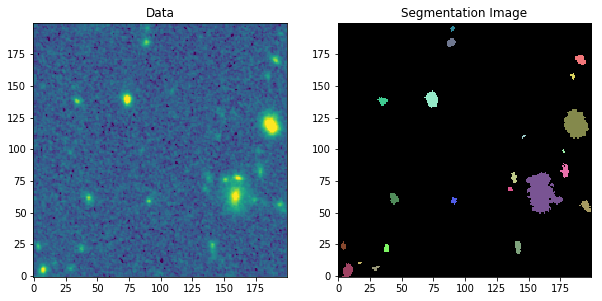

In [43]:
from photutils.utils import random_cmap

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8))
ax1.imshow(data, norm=norm)
lbl1 = ax1.set_title('Data')
ax2.imshow(segm, cmap=segm.cmap())
lbl2 = ax2.set_title('Segmentation Image')

It is better to filter (smooth) the data prior to source detection.

Let's use a 5x5 Gaussian kernel with a FWHM of 2 pixels.

In [44]:
from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma

sigma = 2.0 * gaussian_fwhm_to_sigma    # FWHM = 2 pixels
kernel = Gaussian2DKernel(sigma, x_size=5, y_size=5)
kernel.normalize()

ssegm = detect_sources(data, threshold, npixels, filter_kernel=kernel)

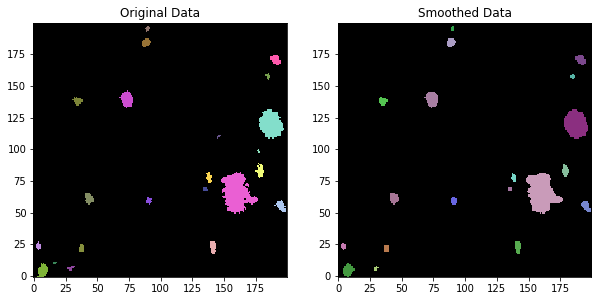

In [45]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8))
ax1.imshow(segm, cmap=segm.cmap())
lbl1 = ax1.set_title('Original Data')
ax2.imshow(ssegm, cmap=ssegm.cmap())
lbl2 = ax2.set_title('Smoothed Data')

### Source deblending

Note above that some of our detected sources were blended.  We can deblend them using the `deblend_sources()` function, which uses a combination of multi-thresholding and watershed segmentation.

/Users/juan/anaconda3/envs/astropy-workshop/lib/python3.5/site-packages/skimage/util/arraycrop.py:175: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cropped = np.array(ar[slices], order=order, copy=True)
        Use max_label instead. [astropy.utils.decorators]


Found 22 sources


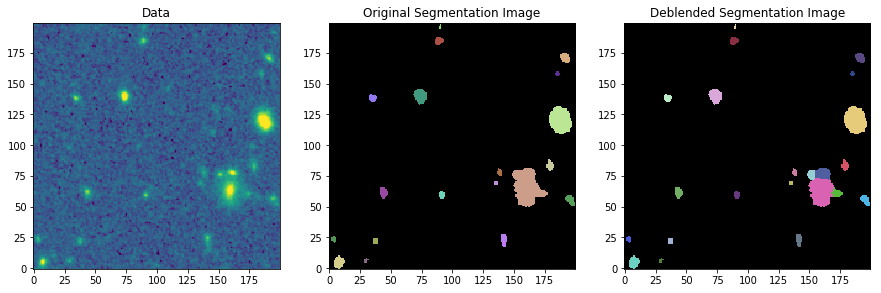

In [46]:
from photutils import deblend_sources

segm2 = deblend_sources(data, ssegm, npixels, filter_kernel=kernel,
                        contrast=0.001, nlevels=32)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 8))
ax1.imshow(data, norm=norm)
ax1.set_title('Data')
ax2.imshow(ssegm, cmap=ssegm.cmap())
ax2.set_title('Original Segmentation Image')
ax3.imshow(segm2, cmap=segm2.cmap())
ax3.set_title('Deblended Segmentation Image')

print('Found {0} sources'.format(segm2.max))

## Measure the photometry and morphological properties of detected sources

In [47]:
from photutils import source_properties
catalog = source_properties(data, segm2, error=error, wcs=wcs)

`catalog` is a `SourceCatalog` object.  It behaves like a list of `SourceProperties` objects, one for each source.

In [48]:
catalog

In [49]:
catalog[0]   # the first source

In [50]:
catalog[0].xcentroid    # the xcentroid of the first source

<Quantity 7.5533147 pix>

Please go [here](http://photutils.readthedocs.org/en/latest/api/photutils.segmentation.SourceProperties.html#photutils.segmentation.SourceProperties) to see the complete list of available source properties.

We can create a Table of isophotal photometry and morphological properties using the ``to_table()`` method of `SourceCatalog`:

In [51]:
tbl = catalog.to_table()
tbl

id,xcentroid,ycentroid,sky_centroid,sky_centroid_icrs,source_sum,source_sum_err,background_sum,background_mean,background_at_centroid,xmin,xmax,ymin,ymax,min_value,max_value,minval_xpos,minval_ypos,maxval_xpos,maxval_ypos,area,equivalent_radius,perimeter,semimajor_axis_sigma,semiminor_axis_sigma,eccentricity,orientation,ellipticity,elongation,covar_sigx2,covar_sigxy,covar_sigy2,cxx,cxy,cyy
,pix,pix,"deg,deg","deg,deg",,,,,,pix,pix,pix,pix,,,pix,pix,pix,pix,pix2,pix,pix,pix,pix,,rad,,,pix2,pix2,pix2,1 / pix2,1 / pix2,1 / pix2
int64,float64,float64,object,object,float64,float64,object,object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,7.553314695516333,5.010501829306161,"53.160458468242005,-27.765908716240137","53.16045491713802,-27.765905807856235",0.3140969689702615,0.007382149242648998,None,None,None,4.0,12.0,0.0,10.0,0.0016270348569378257,0.013324600644409657,11.0,8.0,7.0,5.0,67.0,4.61809077155419,28.97056274847714,2.152277789049281,1.663725301759035,0.6343977723822978,1.28058873137882,0.2269932300449249,1.293649730982456,2.920636841723351,0.511169077448774,4.479644719224701,0.3493684482403228,-0.07973237101161172,0.2277810909618303
2,29.243742267394136,6.223130228476329,"53.160049913524965,-27.76588861601516","53.16004636242952,-27.765885707669323",0.030047482228837907,0.00299605931730985,None,None,None,28.0,31.0,5.0,8.0,0.0018685600953176618,0.004033097997307777,30.0,8.0,29.0,6.0,11.0,1.8712051592547776,10.65685424949238,1.0000337677496938,0.7705009609590648,0.6374702824816553,0.7673272371535811,0.22952505624598118,1.2979007404545255,0.8042119836574845,0.2030652053917651,0.7895272838210062,1.329815661403967,-0.6840530934138133,1.3545493776741093
3,140.89475249322624,23.45912655899891,"53.15794682989969,-27.765601898029036","53.157943278826345,-27.765598989879106",0.13003053539432585,0.005716234401462344,None,None,None,139.0,143.0,18.0,27.0,0.0016787038184702396,0.006731071043759584,139.0,22.0,141.0,25.0,40.0,3.5682482323055424,23.656854249492376,2.4162760408631145,1.13484508744997,0.8828436563098752,-1.5004886294103097,0.5303330131748549,2.129168172452997,1.3103303203737575,-0.3188830475794376,5.8159329577847005,0.7734872022469176,0.08481939462044269,0.17426674978579154
4,37.57504995503402,21.962293185971536,"53.15989290043491,-27.765626338833183","53.159889349312465,-27.76562343050197",0.06266678764950484,0.004048464129814733,None,None,None,36.0,39.0,20.0,24.0,0.001770949806086719,0.004707001149654388,36.0,24.0,38.0,21.0,20.0,2.5231325220201604,14.0,1.3116421627846628,1.0261975514953874,0.622806191969407,-1.5649545140475811,0.21762384542691615,1.2781575641778935,1.0531041880442673,-0.0038982916884051726,1.7203823898452888,0.9495816266858995,0.004303399272884629,0.5812709975732416
5,3.643284534370782,23.72824167960622,"53.16053200676377,-27.76559673412496","53.160528455620714,-27.76559382573421",0.05923816212452948,0.003834152958767743,None,None,None,2.0,5.0,21.0,26.0,0.0018495642580091953,0.005274028051644564,5.0,25.0,4.0,24.0,18.0,2.393653682408596,13.071067811865476,1.3343681210986853,0.8882926571738362,0.7462169386202122,-1.3176082274680707,0.3342971529907067,1.502171733968925,0.8512749837765318,-0.2404382004579082,1.7183271436168586,1.2230448704589203,0.34227092183790486,0.6059076155116804
6,194.74036574633462,55.57240669416572,"53.15693246096231,-27.765066930160202","53.15692890985242,-27.765064022104763",0.14216194639448076,0.006159360692846708,None,None,None,191.0,198.0,51.0,59.0,0.001774212229065597,0.006075085140764713,191.0,56.0,194.0,57.0,46.0,3.826519928662906,24.72792206135785,2.447451650653097,1.3918124788738224,0.822560069451999,-1.0110407075015062,0.4313217674790756,1.7584636492363106,3.079805569833908,-1.8235667252056647,4.847355988799556,0.4177488097488156,0.31431272252850134,0.26541997617437413
7,43.62239333293608,61.473548833019414,"53.1597

Additional properties (not stored in the table) can be accessed directly via the `SourceCatalog` object.

In [52]:
# get a single object (id=12)
obj = catalog[11]
obj.id

12

In [53]:
obj

Let's plot the cutouts of the data and error images for this source.

Text(0.5, 1.0, 'Source id=12 Error')

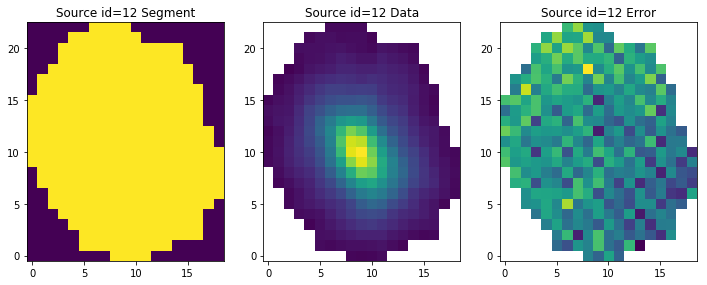

In [54]:
fig, ax = plt.subplots(figsize=(12, 8), ncols=3)
ax[0].imshow(obj.make_cutout(segm2.data))
ax[0].set_title('Source id={} Segment'.format(obj.id))
ax[1].imshow(obj.data_cutout_ma)
ax[1].set_title('Source id={} Data'.format(obj.id))
ax[2].imshow(obj.error_cutout_ma)
ax[2].set_title('Source id={} Error'.format(obj.id))

## More on Image Segmentation in the Extended notebook:

- Define a subset of source labels
- Define a subset of source properties
- Additional sources properties, such a cutout images
- Define the approximate isophotal ellipses for each source

## Also see the two notebooks on Photutils PSF-fitting photometry:

- `gaussian_psf_photometry.ipynb`
- `image_psf_photometry_withNIRCam.ipynb`